In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# A Reinforcement Learning toy problem - visualized

Here, we study a typical toy problem that's often used for introductory courses. An actor finds herself in an environment represented by a board - a 2-dimensional grid. The fields in that grid can have different characteristics, and in our case the characteristic is given by the reward $R$ associated with each field. We have regular fields with a small negative reward, meant to encourage the actor to look for the shortest path, and we have fields that come with great reward or great penalties. You'll see a graphical representation of that field in a minute.


---

### State and environment
We have a stationary environment, i.e. state is solely defined by position and directions of the actor.

In [2]:
class Board():
    """
    Just an intuitively indexed array
    """
    def __init__(self, array):
        self.array = np.array(array)
        self.width = np.shape(array)[1]
        self.height = np.shape(array)[0]
        
    def get(self, x,y):
        return self.array[self.height-y-1][x]
    
    def set(self, x,y,v):
        self.array[self.height-y-1][x] = v
        
    def __repr__(self):
        return str(self.array)

In [3]:
class State:
    def __init__(self, environment, position, direction = [0, 0]):
        self.env = environment
        self.pos = np.array(position)
        self.d = direction
                
    def options(self): 
        """
        All actions that lead to fields with valid rewards
        """
        return [a[0]
            for a in Move.actions(include_none=False).items()
            if not np.isnan(self.env.reward_at(self.pos+a[1]))]

    def is_done(self):
        return self.env.is_done(self.pos)
    
    def go(self, dir):
        new_pos = self.pos + dir
        if new_pos[0] < 0 or new_pos[0] >= self.env.right \
            or new_pos[1] < 0 or  new_pos[1] >= self.env.top:
            new_dir = [0,0]
            new_pos = self.pos
            return State(self.env, new_pos, new_dir)
 
        if np.isnan(self.env.board.get(*new_pos)):
            new_dir=[0, 0]
            new_pos = self.pos
        else:
            new_dir = dir
            self.env.vf_matrix.set(new_pos[0], new_pos[1], 
                                   self.env.bellmann(new_pos))
        return State(self.env, new_pos, new_dir)
        
        
    def show(self):
        """
        Display this state in the context of its environment.
        State refers to an Environment, but the environment doesn't know this state.
        """
        self.env.show(self)
        
    def __repr__(self):
        return "Pos: %s, Dir: %s" % (self.pos, self.d)

In [4]:
class Environment:
    def __init__(self, array, gamma=0.9):
        self.board = Board(array)
        self.top=np.shape(array)[0]
        self.right=np.shape(array)[1]
        self.gamma = gamma
        self.vf_matrix=Board(np.zeros(np.shape(array)))
    
    def show(self, state):
        import seaborn as sns

        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))        
        
        # The board itself as a heat map
        axes = sns.heatmap(self.board.array, annot=True, 
                           cmap='bwr_r', ax=ax1, cbar=False)
        axes.set_xticks([], [])
        axes.set_yticks([], [])
        
        # The actor's position
        axes.plot([state.pos[0]+0.5], [self.top-state.pos[1]-0.5], 
                  'go', markersize=30)
        axes.set_title("World of rewards")
        
        # the actor's direction
        l = np.max([np.sqrt(state.d[0]**2 + state.d[1]**2), 1])
        d = 0.4/l
        axes.plot([state.pos[0]+0.5+d*state.d[0]], 
                  [self.top-state.pos[1]-0.5-d*state.d[1]], 
                  'go', markersize=15)

        # the value function's heat map
        axes = sns.heatmap(self.vf_matrix.array,
                           annot=True, cmap='bwr_r', ax=ax2)
        axes.set_xticks([], [])
        axes.set_yticks([], [])
        axes.set_title('Bellmann values')

        return ""

  
    def bellmann(self, pos):
        """
        The new value of a state according to the bellmann equation
        """

        r = self.reward_at(np.array(pos))
        if r == 1 or r == -1:
            return 0
        best_neighbour = np.max([
            self.reward_at(np.array(pos)+Move.actions()[a]) + 
            self.gamma * self.vf_matrix.get(*(np.array(pos) + Move.actions()[a]))
            for a in State(env, pos).options()])
        return best_neighbour

    def reward_at(self, pos):
        if pos[0] < 0 or pos[0] >= self.right or pos[1] < 0 or pos[1] >= self.top:
            return np.nan
        if np.isnan(self.board.get(*pos)):
            return np.nan
        else:
            return self.board.get(*pos)
    

    def success(self, pos):
        return self.reward_at(pos) == 1
       
    def failure(self, pos):
        return self.reward_at(pos) == -1
  
    def is_done(self, pos):
        return self.failure(pos) or self.success(pos)

    def clear_vf(self):
        self.vf_matrix=Board(np.zeros((self.top, self.right)))    

In [5]:
board = np.array([[-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01],
       [-0.01, -0.01, -0.01, -0.01, -0.01, np.nan, -0.01],
       [-0.01, -0.01, np.nan, -0.01, -0.01, -0.01, -1],
       [-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, 1],
       [-0.01, np.nan, -0.01, -0.01, -1, -0.01, -0.01]])

env = Environment(board)
np.shape(board)

(5, 7)

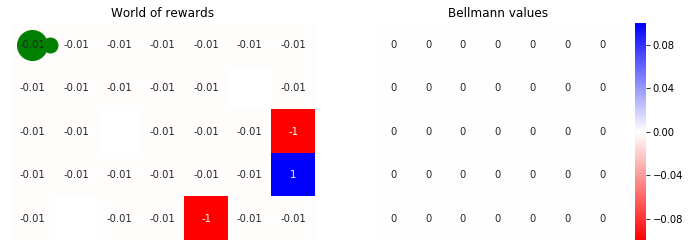

In [6]:
state = State(env,  [0,4], [1, 0])
state.show()

The grey areas are *forbidden*. The State class will simply ignore moves onto those fields - just as well as it will ignore moves that would lead beyond the limits of the board. Note that the Bellmann values will only be updated once the actor starts to move.

In [7]:
env.reward_at([6,2])

-1.0

The state is considered done when the reward is either $1$ or $-1$

In [8]:
state.is_done()

False

---
### Deterministic Moves
Here, a deterministic move is an action in the terminology of Reinforcement Learning. A deterministic move takes a state and returns a new one, namely the particular state where the actor has moved into the given direction. Moves can go into the 8 typical directions.
We modelled moves as classes with a ```__call__()``` method to be able to actually apply a move to a state and return the state new state - with the actor now sitting on a field adjacent to the previously occupied field.

In [9]:
class Move:
    @staticmethod
    def actions(include_none=False):
        all = {
            's': [0,-1], 'w': [-1,0], 'n': [0,1], 'e':[1,0],
            'ne': [1,1], 'nw': [-1,1], 'se': [1,-1], 'sw': [-1, -1]}
        if include_none:
            all['none'] = [0,0]
        return all
    
    @staticmethod
    def compare(d1, d2):
        return np.sign(d1[0]*d2[0] + d1[1]*d2[1])


In [10]:
class DMove(Move):
    "Deterministic action"
  
    def __init__(self, dir):
        self.R=1-1j
        self.L=1+1j
        self.dir = Move.actions(include_none=True)[dir] if type(dir)==str else dir
    
    def __call__(self, state):
        return state.go(self.dir)
    
    def compare(self, other):
        """
        basically the sign of the inner product
        """
        return np.sign(self.dir[0]*other.dir[0] + self.dir[1]*other.dir[1])
  
    def rot_left(self, n=1):
        return self.rot(self.L, n)
  
    def rot_right(self, n=1):
        return self.rot(self.R, n)
  
    def rot(self, A, n=1):
        D= complex(self.dir[0], self.dir[1])
        once = DMove([np.sign(np.real(A*D)), np.sign(np.imag(A*D))])
        return once if n==1 else once.rot(A, n-1)

    def __repr__(self):
        return str(self.dir)

We can already play around with the Moves without knowing the board - the state - yet. Noticed the use of complex numbers for rotation? Cool stuff, huh?

The state *knows* which move options are available 

In [11]:
"State: %s, options: %s " % (state, state.options())

"State: Pos: [0 4], Dir: [1, 0], options: ['s', 'e', 'se'] "

In [12]:
south = DMove('s')
south, south.rot_left() # from south to south-east.

([0, -1], [1.0, -1.0])

```compare()``` returns $1$ if the moves are somewhat parallel in the same direction - $0$, if they're perpendicular and $-1$ if they're somewhat antiparallel. We'll use that feature to make the agents move less *unmotivated*, i.e. we want the agent to avoid going back after she'd made a step into a certain direction. This behaviour will be encoded into her  policy $p(s,a)$ 

In [13]:
south.compare(south.rot_left(3))

-1.0

In [14]:
s, se, e, w = [DMove(i) for i in ['s', 'se', 'e', 'w']]

In [15]:
print(state)
print(e(state))
print(w(state))

Pos: [0 4], Dir: [1, 0]
Pos: [1 4], Dir: [1, 0]
Pos: [0 4], Dir: [0, 0]


Let's take a walk: You need to read the blow code inside out, so the path is e-se-e-e-se-se, which you can observe by the updated Bellmann values in the board plot. When you run the below cell 6 times or more, you can see how the update rule *carves* knowledge about the big reward into the board.

---
### Bellmann equation for deterministic environments

$ V(s) \leftarrow \text{max}_a(R(a(s)) + \gamma \cdot V(a(s)) $, for non-terminal states

$ V(s) \leftarrow 0 $, for terminal states


The Bellmann value is the maximum of the rewards to be expected from the neighborhood. Here, the blue field east of $[5,1]$ determines that value. Note that position $[5,1]$ will assume that value only when the actor moves onto it. This reflects the model assumption that the actor has knowledge only about it's closest environment - namely its adjacent cells.

Pos: [6 1], Dir: [1, -1]


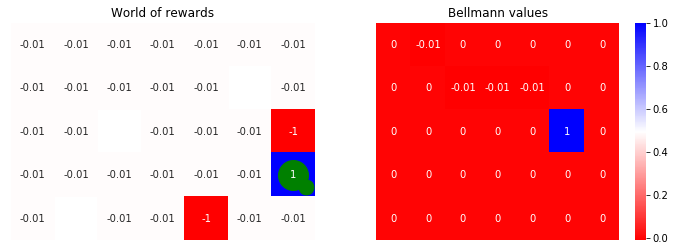

In [16]:
s1 = se(se(e(e(se(e(state)))))) # Moving on to the maximum reward
print(s1)
s1.show()

In [17]:
env.clear_vf()
s1.is_done()

True

---
### The policy

In [20]:
class Policy_epsilon_off:
    """      
    This policy prefers the max reward, but allows epsilon probability for 
    each non-max-expecting action in the direction of the previous move
    """
    def __init__(self, epsilon=.1):
        self.epsilon = epsilon
    
    def __call__(self, s, include_none=False):
        # Look at the neighbours
        neighbours = { a[0]: s.env.reward_at(s.pos+a[1]) 
                   for a in Move.actions(include_none).items()}

        # omit those going somewhat backwards
        filtered = {a[0]: a[1] if Move.compare(DMove(a[0]).dir, s.d) >= 0 else np.nan 
                 for a in neighbours.items()} 
        f2 = [ a[0] for a in filtered.items() if not np.isnan(a[1])]
        if len(f2) > 0:
            #print ('filtered: %s' % filtered)
            return self.policy(filtered)
        else:
            return self.policy(neighbours)
            #print ('all neighbours: %s' % neighbours)
  
  
    def policy(self, environ):
        # The number of possible directions
        lenr = len([i[1] for i in environ.items() if not np.isnan(i[1])])

        # The max return (maybe multiple)
        maxr = np.max([i[1] for i in environ.items() if not np.isnan(i[1])])

        # The number of values equal to the max
        lenm = len([i[1] for i in environ.items() 
                    if not np.isnan(i[1]) and i[1]==maxr])

        pmax = (1 - (lenr-lenm) * self.epsilon) / lenm

        return { i[0]: pmax if i[1] == maxr else .1
                if not np.isnan(i[1]) else 0 
                for i in environ.items()}
  
  
    def draw(self, s, include_none=False):
        """
        Choose an action according to the given epsilon-greedy distribution
        """
        d = self.__call__(s, include_none)
        keys = ['s', 'w', 'e', 'n', 'se', 'ne', 'sw', 'nw']
        if include_none:
            keys.append('none')
        values = np.cumsum([ d[k] for k in keys])
        values = np.insert(values, 0,0)
        index = np.digitize(np.random.uniform(), values)-1
        return keys[index]

In [21]:
p = Policy_epsilon_off(.1)
p(state)

{'e': 0.3333333333333333,
 'n': 0,
 'ne': 0,
 'nw': 0,
 's': 0.3333333333333333,
 'se': 0.3333333333333333,
 'sw': 0,
 'w': 0}

Our policy provides a distribution for choosing the next action somewhat *not-so-greedy*. And it prohibits going back. Observe that since the last move below is going east, our policy after that step omits all options that have an western component. 

In [22]:
p = Policy_epsilon_off(.1)
e, w = [DMove(i) for i in ['e', 'w']]
s1 = e(w(w(s1)))
p(s1)

{'e': 0.6, 'n': 0.1, 'ne': 0.1, 'nw': 0, 's': 0.1, 'se': 0.1, 'sw': 0, 'w': 0}

You can see the policy in action if you draw from the distribution that it establishes:

In [23]:
p = Policy_epsilon_off(.1)
bins={'none': 0, 'n': 0, 'e': 0, 's': 0, 'w': 0, 'ne': 0, 'se': 0, 'sw': 0, 'nw': 0}
for i in range(10000):
  bins[p.draw(s1, include_none=False)]+=1
bins

{'e': 5955,
 'n': 1049,
 'ne': 974,
 'none': 0,
 'nw': 0,
 's': 1011,
 'se': 1011,
 'sw': 0,
 'w': 0}

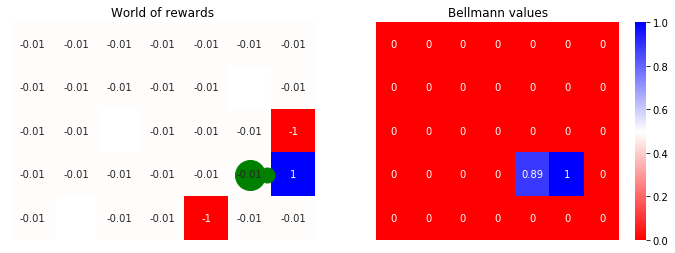

In [24]:
s1.show()

## RL: Learning by eploration and exploitation
The goal of our toy problem is to find the most rewarding path from any starting point in the board. That requires a policy that balances exploitation (being greedy) and exploration (being curious). After the learning process, any greedy policy should be able to find the best path by always choosing the field with the highest value for the sum of its Bellmann value and its reward.

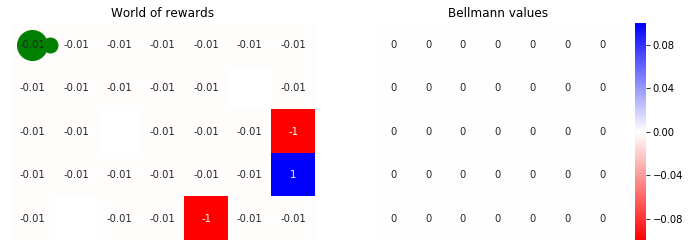

In [28]:
state = State(env,  [0,4], [1, 0])
env.clear_vf()
state.show()

''

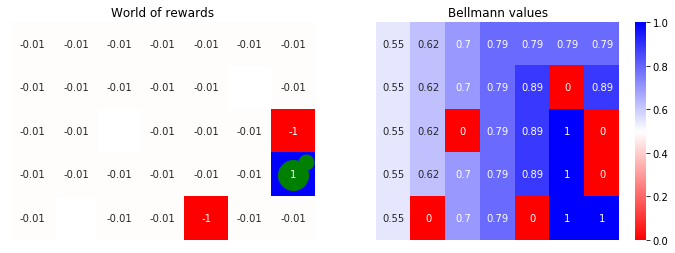

In [32]:
p = Policy_epsilon_off(.1)
num_episodes = 100
env.clear_vf()
for n in range(num_episodes):
    s = State(env, [0,4], [1, 0])
    while not s.is_done():
        action = p.draw(s)
        s = DMove(action)(s)
env.show(s)